In [1]:
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv(r'C:\Users\Dell\glassidentification.csv')
features = df.columns[:-1].tolist()
print(df.shape)

(213, 11)


In [3]:
df.head(15)

,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00.1,1.1
0,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
1,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
2,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
3,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
4,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
5,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
6,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
7,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
8,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1
9,11,1.51571,12.72,3.46,1.56,73.20,0.67,8.09,0.0,0.24,1


In [4]:
df.dtypes

1            int64
1.52101    float64
13.64      float64
4.49       float64
1.10       float64
71.78      float64
0.06       float64
8.75       float64
0.00       float64
0.00.1     float64
1.1          int64
dtype: object

In [5]:
df.describe()

,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00.1,1.1
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,108.000000,1.518353,13.406761,2.676056,1.446526,72.655023,0.499108,8.957934,0.175869,0.057277,2.788732
std,61.631972,0.003039,0.818371,1.440453,0.499882,0.774052,0.653035,1.426435,0.498245,0.097589,2.105130
min,2.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,55.000000,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000,1.000000
50%,108.000000,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,161.000000,1.519150,13.830000,3.600000,1.630000,73.090000,0.610000,9.180000,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,3.980000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


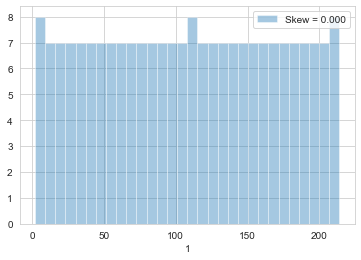

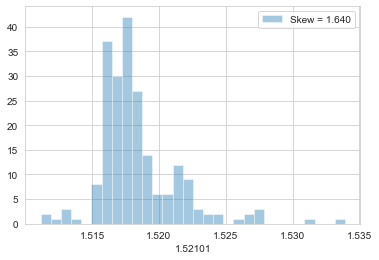

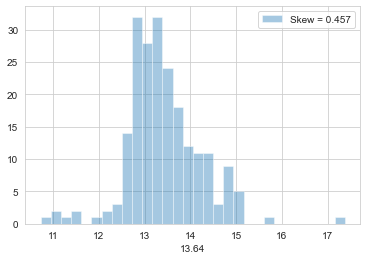

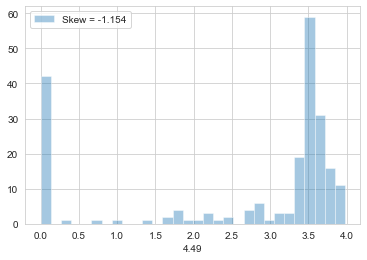

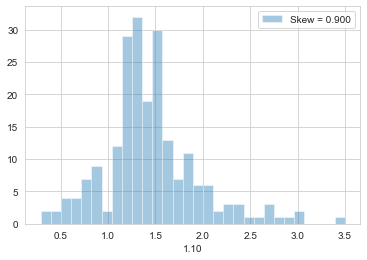

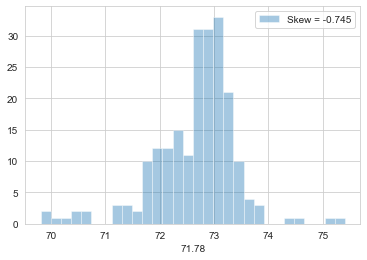

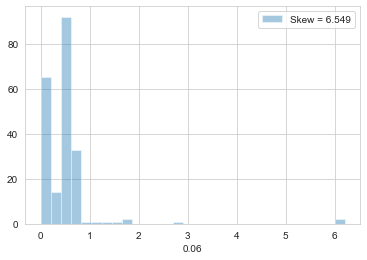

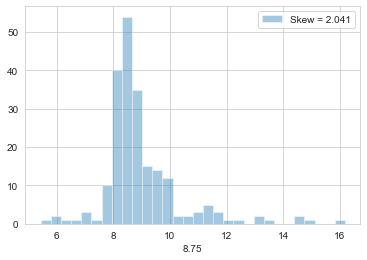

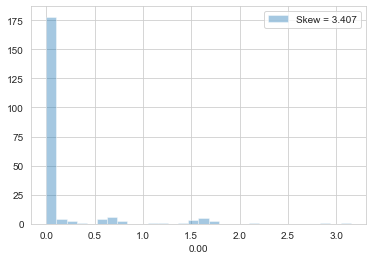

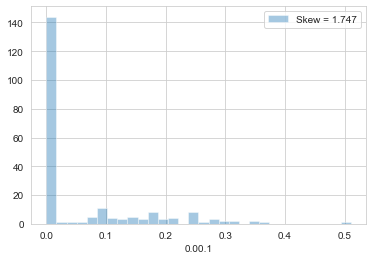

In [6]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [7]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))   

The dataset contains 14 observations with more than 2 outliers


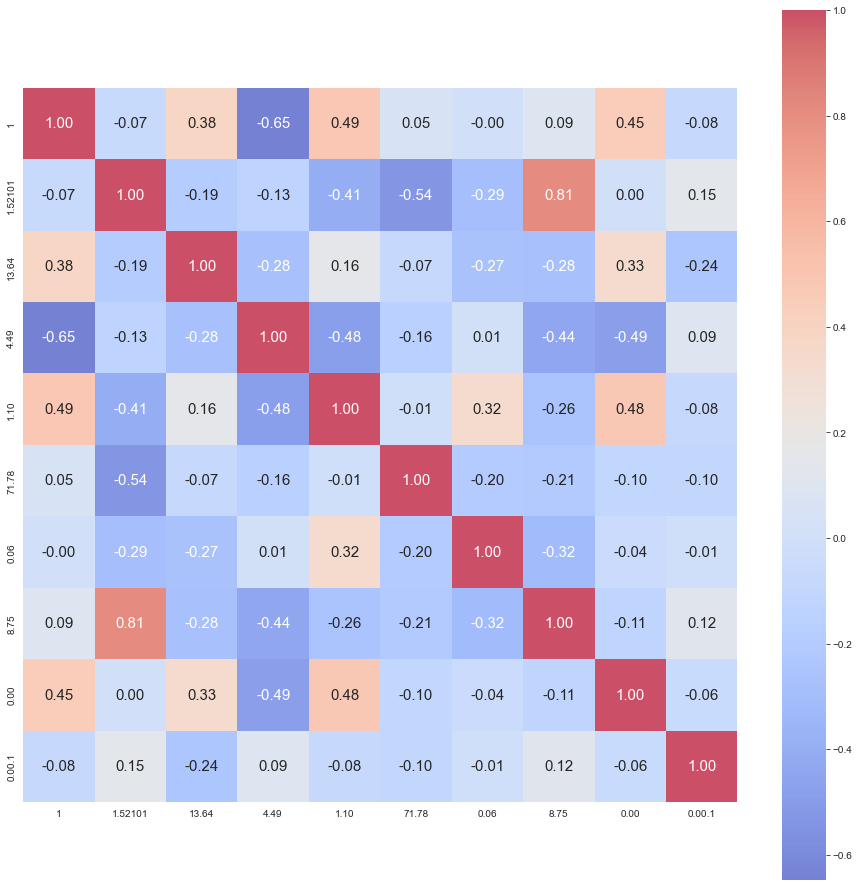

In [9]:
corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   1        213 non-null    int64  
 1   1.52101  213 non-null    float64
 2   13.64    213 non-null    float64
 3   4.49     213 non-null    float64
 4   1.10     213 non-null    float64
 5   71.78    213 non-null    float64
 6   0.06     213 non-null    float64
 7   8.75     213 non-null    float64
 8   0.00     213 non-null    float64
 9   0.00.1   213 non-null    float64
 10  1.1      213 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.4 KB


In [11]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(199, 11)


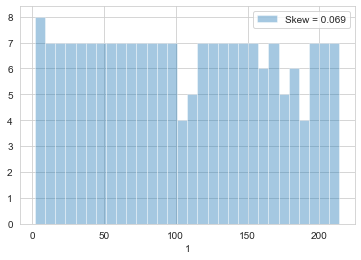

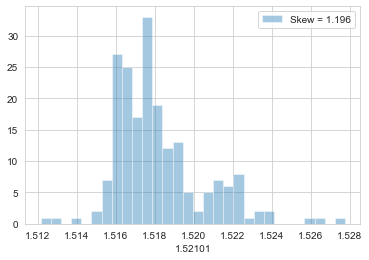

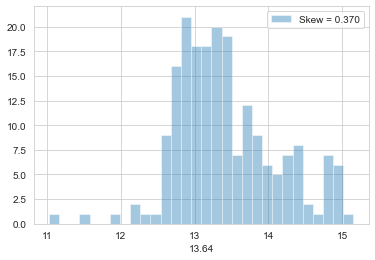

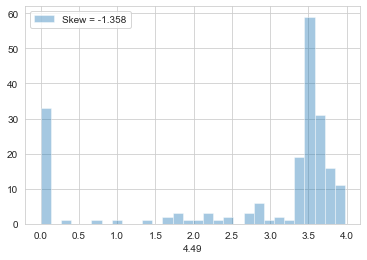

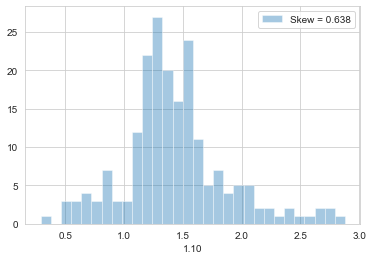

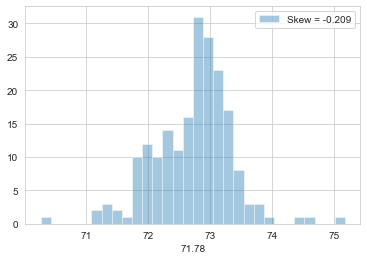

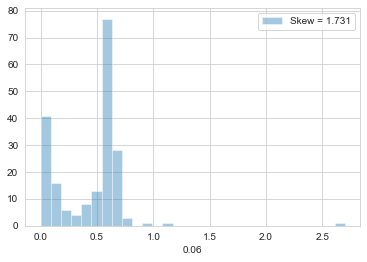

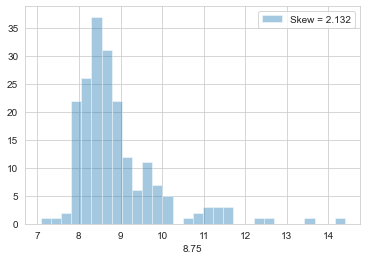

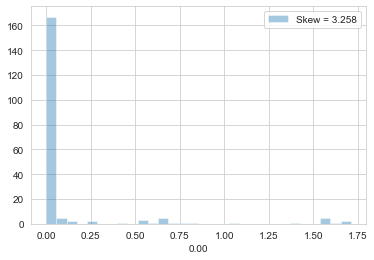

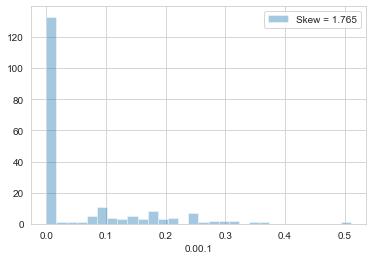

In [12]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [17]:
df_bc.describe()

,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00.1
count,199.000000,1.990000e+02,199.000000,199.000000,199.000000,1.990000e+02,199.000000,1.990000e+02,199.000000,199.000000
mean,31.305109,6.100197e-04,0.891559,15.387327,0.961304,1.051247e+10,0.345011,2.000248e-01,0.013508,0.019346
std,14.376674,1.413018e-18,0.002868,8.318352,0.220205,5.078253e+08,0.213716,8.648674e-07,0.031406,0.027959
min,1.627321,6.100197e-04,0.879736,0.000000,0.261767,8.628799e+09,0.000000,2.000214e-01,0.000000,0.000000
25%,19.923802,6.100197e-04,0.889608,10.366953,0.854094,1.020811e+10,0.127451,2.000243e-01,0.000000,0.000000
50%,32.008296,6.100197e-04,0.891218,19.324245,0.943348,1.058735e+10,0.448273,2.000247e-01,0.000000,0.000000
75%,43.399679,6.100197e-04,0.893261,20.738611,1.068209,1.081285e+10,0.481538,2.000253e-01,0.000000,0.051872
max,53.872207,6.100197e-04,0.898132,25.489394,1.574985,1.268684e+10,1.400354,2.000270e-01,0.091630,0.069336


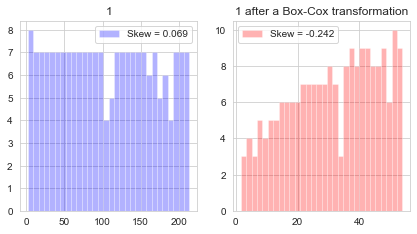

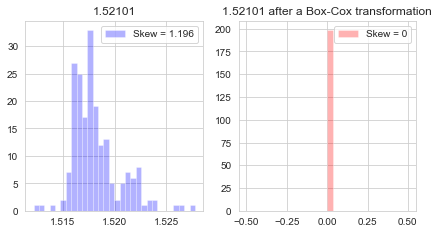

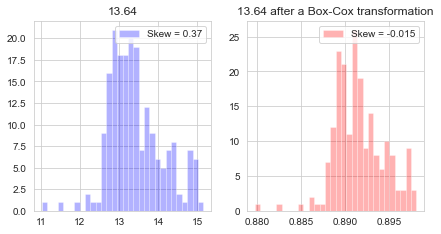

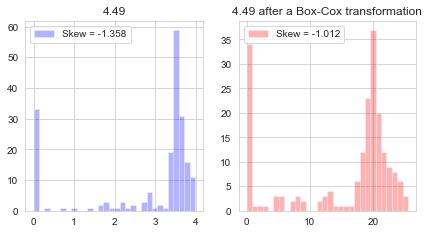

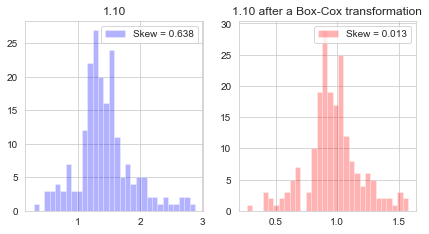

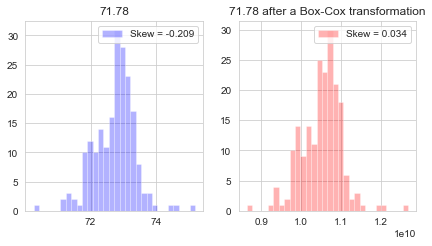

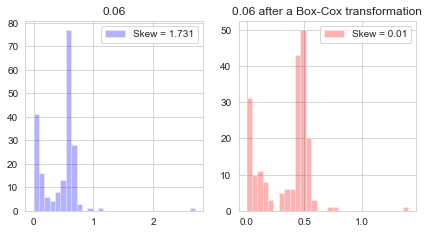

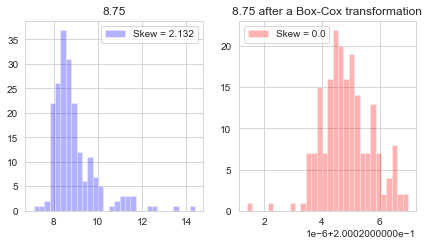

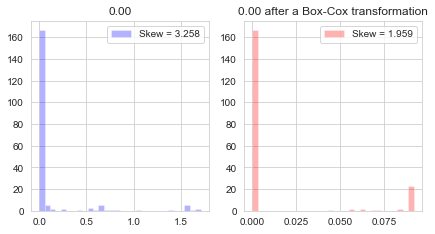

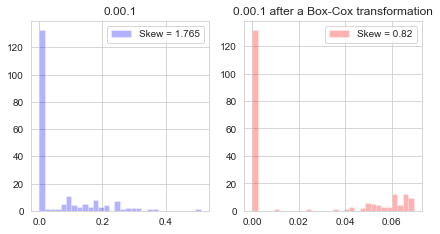

In [18]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [19]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature 1 is more skewed after a Box-Cox transform
Feature 1.52101 is less skewed after a Box-Cox transform
Feature 13.64 is less skewed after a Box-Cox transform
Feature 4.49 is less skewed after a Box-Cox transform
Feature 1.10 is less skewed after a Box-Cox transform
Feature 71.78 is less skewed after a Box-Cox transform
Feature 0.06 is less skewed after a Box-Cox transform
Feature 8.75 is less skewed after a Box-Cox transform
Feature 0.00 is less skewed after a Box-Cox transform
Feature 0.00.1 is less skewed after a Box-Cox transform


In [26]:
# Let's define some utility functions to plot the learning & validation curves

def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel('Accuracy')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()    
    
def plot_validation_curve(param_range, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(param_range,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(param_range, test_mean, label='test score', color='red', marker='o')
    plt.fill_between(param_range,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.grid(ls='--')
    plt.xlabel('Parameter value')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()    

In [27]:
plt.figure(figsize=(9,6))

train_sizes, train_scores, test_scores = learning_curve(
              estimator= grid_rfc.best_estimator_ , X= X_train, y = y_train, 
                train_sizes=np.arange(0.1,1.1,0.1), cv= 10,  scoring='accuracy', n_jobs= - 1)

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for RFC')

NameError: name 'grid_rfc' is not defined

<Figure size 648x432 with 0 Axes>